Importing Data from Excel

In [6]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi, voronoi_plot_2d

# Load in Coordinates from Excel (only consider unique coordinate instances)
coord = pd.read_excel('2015_to_2019.xlsx')

coord_unique = coord.drop_duplicates(subset=['Latitude', 'Longitude'])
points = coord_unique[['Longitude','Latitude']].to_numpy()

Plotting Voronoi

Text(0, 0.5, 'Latitude')

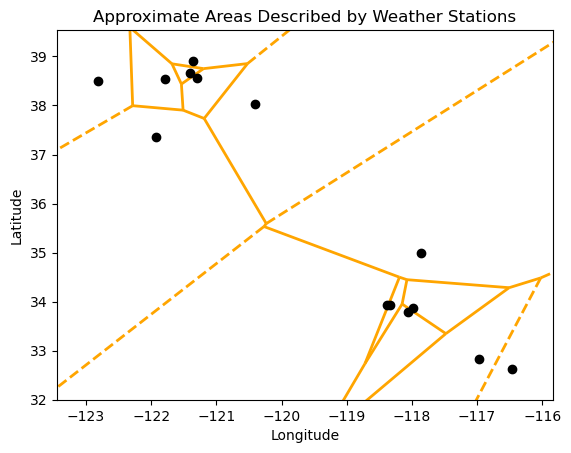

In [5]:
vor = Voronoi(points)
fig, ax = plt.subplots()
patches = []
colors = []

voronoi_plot_2d(vor, ax=ax, show_vertices = False, line_colors = 'orange', line_width = 2)

ax.plot(points[:,0], points[:,1], 'ko')
ax.set_title('Approximate Areas Described by Weather Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(0, 0.5, 'Latitude')

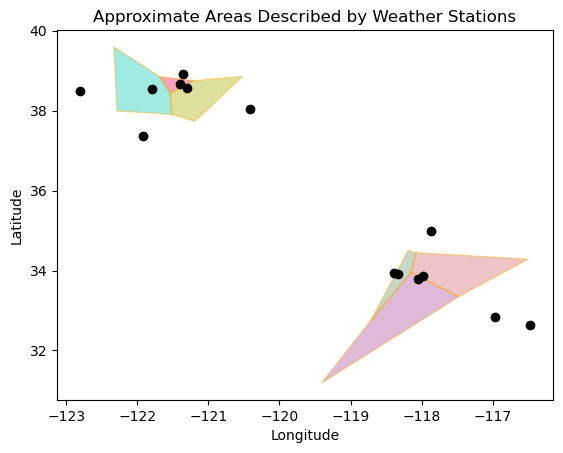

In [9]:
vor = Voronoi(points)
fig, ax = plt.subplots()
patches = []
colors = []

for region_index in vor.regions:
    if not region_index or -1 in region_index:
        continue
    polygon = [vor.vertices[i] for i in region_index]
    poly_patch = Polygon(polygon, closed = True)
    patches.append(poly_patch)
    colors.append(np.random.rand(3))

p = PatchCollection(patches, facecolor = colors, edgecolor = 'orange', alpha = 0.4)
ax.add_collection(p)
ax.plot(points[:,0], points[:,1], 'ko')
ax.set_title('Approximate Areas Described by Weather Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [20]:
def voronoi_finite_polygons_2d(vor, radius = 1e2):
    from collections import defaultdict
    
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = defaultdict(list)

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        #all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges[p1].append((p2, v1, v2))
        #all_ridges.setdefault(p2, []).append((p1, v1, v2))
        all_ridges[p2].append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            #new_regions.append(region)
            polygon = [vor.vertices[i] for i in region]
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 == -1:
                v1, v2 = v2, v1
            if v1 != -1:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[[p1, p2]].mean(axis = 0)
            farpoint = midpoint + n*radius
            new_vertices.append(farpoint.tolist())
            new_region.append(len(new_vertices) - 1)
        vs = np.array([new_vertices[i] for i in new_region])
        c = vs.mean(axis = 0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [new_region[i] for i in np.argsort(angles)]

        new_regions.append(new_region)
        
    return new_regions, np.asarray(new_vertices)

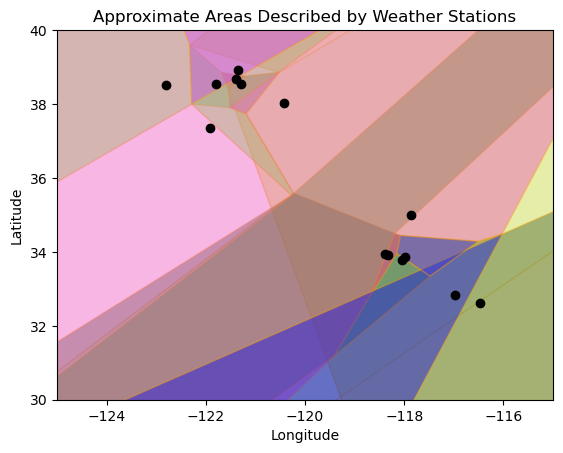

In [22]:
vor = Voronoi(points)

regions, vertices = voronoi_finite_polygons_2d(vor)

fig, ax = plt.subplots()
patches = []
colors = []

for region in regions:
    polygon = vertices[region]
    poly_patch = Polygon(polygon, closed = True)
    patches.append(poly_patch)
    colors.append(np.random.rand(3))

p = PatchCollection(patches, facecolor = colors, edgecolor = 'orange', alpha = 0.4)
ax.add_collection(p)
ax.plot(points[:,0], points[:,1], 'ko')
ax.set_title('Approximate Areas Described by Weather Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.ylim(30,40)
plt.xlim(-125,-115)
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

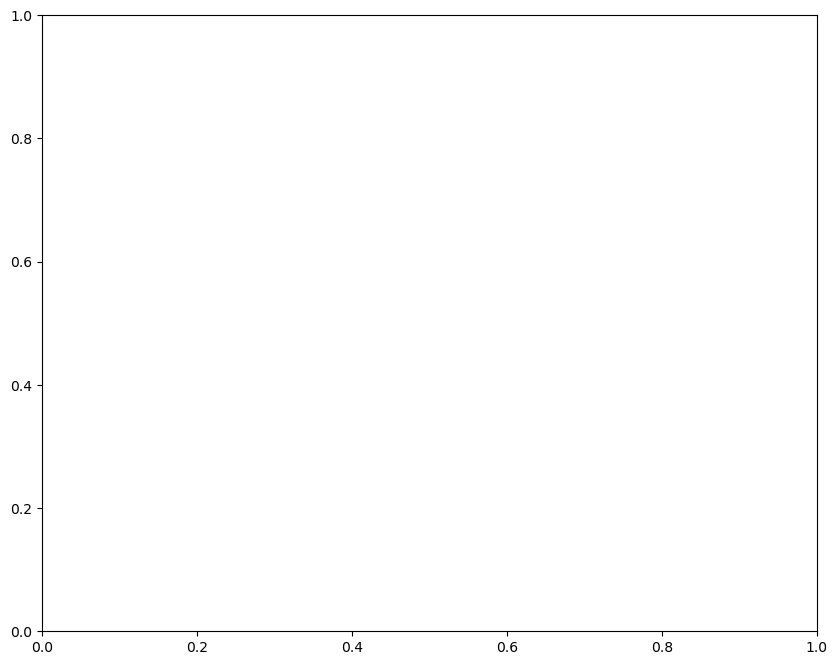

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd
from matplotlib.patches import Patch
from descartes import PolygonPatch

# Load coordinates
df = pd.read_excel('2015_to_2019.xlsx')
df_unique = df.drop_duplicates(subset=['Latitude', 'Longitude'])
points = df_unique[['Longitude', 'Latitude']].to_numpy()

# Build Voronoi diagram
vor = Voronoi(points)

# Function to reconstruct Voronoi regions as finite polygons
def voronoi_finite_polygons_2d(vor, radius=1000):
    from collections import defaultdict

    new_regions = []
    new_vertices = vor.vertices.tolist()
    all_ridges = defaultdict(list)

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges[p1].append((p2, v1, v2))
        all_ridges[p2].append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 == -1:
                v1, v2 = v2, v1
            if v1 != -1:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            far_point = midpoint + n * radius

            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        # Sort vertices
        vs = np.array([new_vertices[i] for i in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = [new_region[i] for i in np.argsort(angles)]

        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)

# Get Voronoi regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# -----------------------------
# Load the state boundary
# Replace 'state_boundary.shp' with your shapefile or GeoJSON
gdf = gpd.read_file('CA_State.shp')
gdf = gdf.to_crs("EPSG:4326")
state_shape = gdf.geometry.union_all()

# -----------------------------
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

for region in regions:
    if not region or any(i is None or i < 0 or i >= len(vertices) for i in region):
        continue  # Skip bad regions
    polygon_coords = vertices[region]
    poly = Polygon(polygon_coords)

    # Clip Voronoi polygon to the state shape
    clipped_poly = poly.intersection(state_shape)

    # Only plot if there's an intersection
    if not clipped_poly.is_empty:
        patch = PolygonPatch(clipped_poly, facecolor=np.random.rand(3,), edgecolor='black', alpha=0.5)
        ax.add_patch(patch)

# Plot original points
ax.plot(points[:, 0], points[:, 1], 'ko', markersize=4, label='Weather Stations')

# Plot the state border
gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Legend, labels
ax.set_title("Voronoi Diagram Clipped to State Boundary")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
ax.set_aspect('equal')
plt.show()

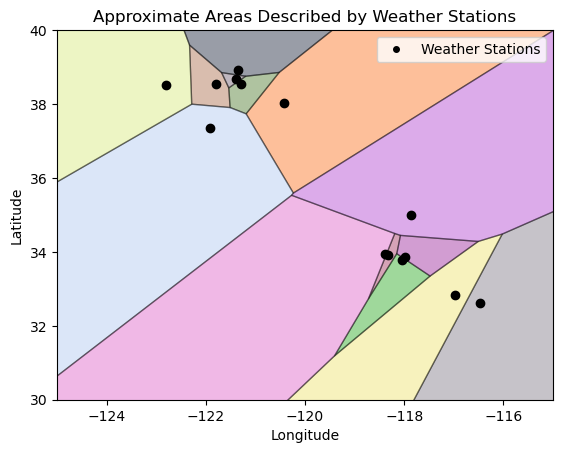

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi, voronoi_plot_2d

# make up data points
coord = pd.read_excel('2015_to_2019.xlsx')

coord_unique = coord.drop_duplicates(subset=['Latitude', 'Longitude'])
points = coord_unique[['Longitude','Latitude']].to_numpy()

# add 4 distant dummy points
points = np.append(points, [[-200,80], [-200,0], [-100,80], [-100,0]], axis = 0)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
fig, ax = plt.subplots()
patches = []
colors = []

for region_index in vor.regions:
    if not region_index or -1 in region_index:
        continue
    polygon = [vor.vertices[i] for i in region_index]
    poly_patch = Polygon(polygon)
    patches.append(poly_patch)
    colors.append(np.random.rand(3))

p = PatchCollection(patches, facecolor = colors, edgecolor = 'black', alpha = 0.4)
ax.add_collection(p)
ax.plot(points[:,0], points[:,1], 'ko')
ax.set_title('Approximate Areas Described by Weather Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.plot(points[:, 0], points[:, 1], 'ko', markersize=4, label='Weather Stations')
ax.legend()

# colorize
#for region in vor.regions:
#    if not -1 in region:
#        polygon = [vor.vertices[i] for i in region]
#        plt.fill(*zip(*polygon))

# fix the range of axes
plt.ylim(30,40)
plt.xlim(-125,-115)
plt.show()